## Data Wrangling <a name="wrangling"></a>
#### Data sources
- Data/raw/Seasons_Stats.csv [kaggle dataset](https://www.kaggle.com/drgilermo/nba-players-stats).<br>
- Data/raw/draft78.csv [kaggle dataset](https://www.kaggle.com/amiles/nbadraftvalue).<br>
- Incomplete/missing data were scraped from [basketball-reference.com](https://www.basketball-reference.com)

## Table of contents <a name="contents"></a>
* [1. Load the data](#data)
* [2. Scrape missing data](#scrape)
* [3. Remove players with duplicate names](#3)
* [4. Get draft data](#4)
* [5. Deal with players traded mid-season](#5)
* [6. Fix discrepencies caused by short seasons](#6)
* [7. Check outliers](#7)
* [8. Impute missing values](#8)
* [9. Simple feature selection and modification](#9)

## 1. Load the data <a name="data"></a>

[**Back to Contents*](#contents)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import lxml.html as lh
%matplotlib inline
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

In [2]:
# Read the player season stats data
season_stats = pd.read_csv('./data/raw/Seasons_Stats.csv', index_col=0)
# Remove two blank columns
season_stats.drop(['blanl', 'blank2'], axis=1, inplace=True)
season_stats.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,0.368,NaN,0.467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.1,3.6,3.5,NaN,NaN,NaN,NaN,NaN,144.0,516.0,0.279,NaN,NaN,NaN,144.0,516.0,0.279,0.279,170.0,241.0,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,0.435,NaN,0.387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,0.6,2.2,NaN,NaN,NaN,NaN,NaN,102.0,274.0,0.372,NaN,NaN,NaN,102.0,274.0,0.372,0.372,75.0,106.0,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,0.394,NaN,0.259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,2.8,3.6,NaN,NaN,NaN,NaN,NaN,174.0,499.0,0.349,NaN,NaN,NaN,174.0,499.0,0.349,0.349,90.0,129.0,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,0.312,NaN,0.395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,-0.1,-0.6,NaN,NaN,NaN,NaN,NaN,22.0,86.0,0.256,NaN,NaN,NaN,22.0,86.0,0.256,0.256,19.0,34.0,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,0.308,NaN,0.378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,-0.1,-0.6,NaN,NaN,NaN,NaN,NaN,21.0,82.0,0.256,NaN,NaN,NaN,21.0,82.0,0.256,0.256,17.0,31.0,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


In [3]:
season_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24691 entries, 0 to 24690
Data columns (total 50 columns):
Year      24624 non-null float64
Player    24624 non-null object
Pos       24624 non-null object
Age       24616 non-null float64
Tm        24624 non-null object
G         24624 non-null float64
GS        18233 non-null float64
MP        24138 non-null float64
PER       24101 non-null float64
TS%       24538 non-null float64
3PAr      18839 non-null float64
FTr       24525 non-null float64
ORB%      20792 non-null float64
DRB%      20792 non-null float64
TRB%      21571 non-null float64
AST%      22555 non-null float64
STL%      20792 non-null float64
BLK%      20792 non-null float64
TOV%      19582 non-null float64
USG%      19640 non-null float64
OWS       24585 non-null float64
DWS       24585 non-null float64
WS        24585 non-null float64
WS/48     24101 non-null float64
OBPM      20797 non-null float64
DBPM      20797 non-null float64
BPM       20797 non-null float64
VOR

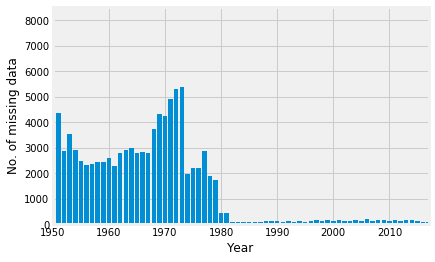

In [4]:
# There were some missing data
# Let's see which years are the missing data from
missing_data = season_stats.groupby('Year').apply(lambda x:x.isnull().sum()).sum(axis=1)
# Bar plot
_ = plt.bar(missing_data.index, missing_data)
_ = plt.xlabel('Year')
_ = plt.ylabel('No. of missing data')
_ = plt.xlim([1950, 2017])

#### Note 1:
NBA introduced the 3-point shot in the 1980 season. NBA started tracking blocks, steals, turnovers, etc. in the 70s. <br>
Using the data from the 1980 season to present.

In [5]:
# Discard seasons before 1980
season_stats_1980_2018 = season_stats[season_stats['Year']>=1980]
# delete the og data to save memory
del season_stats

In [10]:
season_stats_1980_2018.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
5727,1980.0,Kareem Abdul-Jabbar*,C,32.0,LAL,82.0,NaN,3143.0,25.3,0.639,0.001,0.344,7.2,22.2,15.4,16.5,1.2,4.6,15.7,24.1,9.5,5.3,14.8,0.227,4.0,2.7,6.7,6.8,835.0,1383.0,0.604,0.0,1.0,0.000,835.0,1382.0,0.604,0.604,364.0,476.0,0.765,190.0,696.0,886.0,371.0,81.0,280.0,297.0,216.0,2034.0
5728,1980.0,Tom Abernethy,PF,25.0,GSW,67.0,NaN,1222.0,11.0,0.511,0.003,0.258,5.4,12.0,8.6,9.3,1.4,0.6,9.9,13.3,1.2,0.8,2.0,0.080,-1.5,-0.1,-1.6,0.1,153.0,318.0,0.481,0.0,1.0,0.000,153.0,317.0,0.483,0.481,56.0,82.0,0.683,62.0,129.0,191.0,87.0,35.0,12.0,39.0,118.0,362.0
5729,1980.0,Alvan Adams,C,25.0,PHO,75.0,NaN,2168.0,19.2,0.571,0.002,0.270,8.2,22.4,15.4,21.6,2.3,1.4,18.2,21.9,3.1,3.9,7.0,0.155,1.6,2.8,4.4,3.5,465.0,875.0,0.531,0.0,2.0,0.000,465.0,873.0,0.533,0.531,188.0,236.0,0.797,158.0,451.0,609.0,322.0,108.0,55.0,218.0,237.0,1118.0
5730,1980.0,Tiny Archibald*,PG,31.0,BOS,80.0,80.0,2864.0,15.3,0.574,0.023,0.548,2.3,5.3,3.8,30.2,1.7,0.2,19.7,17.0,5.9,2.9,8.9,0.148,1.1,-1.1,0.0,1.5,383.0,794.0,0.482,4.0,18.0,0.222,379.0,776.0,0.488,0.485,361.0,435.0,0.830,59.0,138.0,197.0,671.0,106.0,10.0,242.0,218.0,1131.0
5731,1980.0,Dennis Awtrey,C,31.0,CHI,26.0,NaN,560.0,7.4,0.524,0.000,0.833,6.0,16.9,11.5,9.0,1.0,1.5,24.8,7.9,0.1,0.5,0.6,0.053,-2.9,1.5,-1.4,0.1,27.0,60.0,0.450,0.0,0.0,NaN,27.0,60.0,0.450,0.450,32.0,50.0,0.640,29.0,86.0,115.0,40.0,12.0,15.0,27.0,66.0,86.0


## 2. Scrape missing data <a name="scrape"></a>

- We only have data before 2017, need to get data from 2017 to present
- Scrape the data from Internet(basketball-reference.com)

[**Back to Contents*](#contents)

In [6]:
def season_stats_scraper(url):
    # Get the page content
    page = requests.get(url)
    doc = lh.fromstring(page.content)
    # Extract the table from page
    tr_elements = doc.xpath('//tr')
    # First row is column names, if blank replace with 'blank'
    cols = [t.text_content() if t.text_content() != u'\xa0'\
                             else 'blank' for t in tr_elements[0]]
    tr_elements.pop(0)
    # Read the rest of rows
    cols_data = [[] for i in cols]
    for row in tr_elements:
        # The table on the website repeats its column names every 20 rows or so
        # Let's check for those and skip them
        if row[0].text_content() == 'Rk':
            continue
        for col_index, col in enumerate(row.iterchildren()):
            col_text = col.text_content()
            #try to convert to numbers
            try:
                if col_text == '':
                    num = np.nan
                else:
                    num = float(col_text)
                cols_data[col_index].append(num)
            except:
                cols_data[col_index].append(col_text)
    # Make dataframe
    df = pd.DataFrame(dict(zip(cols, cols_data)), columns=cols)
    # Drop blank columns if the dataframe has one
    if 'blank' in cols:
        df = df.drop('blank', axis=1)
    return df

In [7]:
# Scrape the 2018 season advanced stats
url = 'https://www.basketball-reference.com/leagues/NBA_2018_advanced.html'
adv_data_2018 = season_stats_scraper(url)
# Scrape the 2018 season total stats
url = 'https://www.basketball-reference.com/leagues/NBA_2018_totals.html'
tot_data_2018 = season_stats_scraper(url)

# Scrape the 2018 season advanced stats
url = 'https://www.basketball-reference.com/leagues/NBA_2019_advanced.html'
adv_data_2019 = season_stats_scraper(url)
# Scrape the 2018 season total stats
url = 'https://www.basketball-reference.com/leagues/NBA_2019_totals.html'
tot_data_2019 = season_stats_scraper(url)

In [8]:
# Drop the duplicate columns from tot_data_2018
duplicated = tot_data_2018.columns.isin(adv_data_2018.columns)
duplicated_columns = tot_data_2018.columns[duplicated]
tot_data_2018.drop(duplicated_columns, axis=1, inplace=True)
# Merge the two dataframes
data_2018 = pd.concat([adv_data_2018, tot_data_2018], axis=1)
# Drop the 'Rk' column and add a 'Year' column
data_2018.drop('Rk', axis=1, inplace=True)
data_2018.insert(0, 'Year', 2018)
data_2018.head()

,Year,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,GS,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,2018,Álex Abrines,SG,24.0,OKC,75.0,1134.0,9.0,0.567,0.759,0.158,2.5,8.9,5.6,3.4,1.7,0.6,7.4,12.7,1.3,1.0,2.2,0.094,-0.5,-1.7,-2.2,-0.1,8.0,115.0,291.0,0.395,84.0,221.0,0.380,31.0,70.0,0.443,0.540,39.0,46.0,0.848,26.0,88.0,114.0,28.0,38.0,8.0,25.0,124.0,353.0
1,2018,Quincy Acy,PF,27.0,BRK,70.0,1359.0,8.2,0.525,0.800,0.164,3.1,17.1,10.0,6.0,1.2,1.6,13.3,14.4,-0.1,1.1,1.0,0.036,-2.0,-0.2,-2.2,-0.1,8.0,130.0,365.0,0.356,102.0,292.0,0.349,28.0,73.0,0.384,0.496,49.0,60.0,0.817,40.0,217.0,257.0,57.0,33.0,29.0,60.0,149.0,411.0
2,2018,Steven Adams,C,24.0,OKC,76.0,2487.0,20.6,0.630,0.003,0.402,16.6,13.9,15.3,5.5,1.8,2.8,13.3,16.7,6.7,3.0,9.7,0.187,2.2,1.1,3.3,3.3,76.0,448.0,712.0,0.629,0.0,2.0,0.000,448.0,710.0,0.631,0.629,160.0,286.0,0.559,384.0,301.0,685.0,88.0,92.0,78.0,128.0,215.0,1056.0
3,2018,Bam Adebayo,C,20.0,MIA,69.0,1368.0,15.7,0.570,0.021,0.526,9.7,21.6,15.6,11.0,1.2,2.5,13.6,15.9,2.3,1.9,4.2,0.148,-1.6,1.8,0.2,0.8,19.0,174.0,340.0,0.512,0.0,7.0,0.000,174.0,333.0,0.523,0.512,129.0,179.0,0.721,118.0,263.0,381.0,101.0,32.0,41.0,66.0,138.0,477.0
4,2018,Arron Afflalo,SG,32.0,ORL,53.0,682.0,5.8,0.516,0.432,0.160,0.6,10.1,5.3,6.2,0.3,1.1,10.8,12.5,-0.1,0.2,0.1,0.009,-4.1,-1.8,-5.8,-0.7,3.0,65.0,162.0,0.401,27.0,70.0,0.386,38.0,92.0,0.413,0.485,22.0,26.0,0.846,4.0,62.0,66.0,30.0,4.0,9.0,21.0,56.0,179.0


In [9]:
# Drop the duplicate columns from tot_data_2018
duplicated = tot_data_2019.columns.isin(adv_data_2019.columns)
duplicated_columns = tot_data_2019.columns[duplicated]
tot_data_2019.drop(duplicated_columns, axis=1, inplace=True)
# Merge the two dataframes
data_2019 = pd.concat([adv_data_2019, tot_data_2019], axis=1)
# Drop the 'Rk' column and add a 'Year' column
data_2019.drop('Rk', axis=1, inplace=True)
data_2019.insert(0, 'Year', 2019)
data_2019.head()

,Year,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,GS,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,2019,Álex Abrines,SG,25.0,OKC,31.0,588.0,6.3,0.507,0.809,0.083,0.9,7.8,4.2,4.3,1.3,0.9,7.9,12.2,0.1,0.6,0.6,0.053,-2.4,-0.9,-3.4,-0.2,2.0,56.0,157.0,0.357,41.0,127.0,0.323,15.0,30.0,0.500,0.487,12.0,13.0,0.923,5.0,43.0,48.0,20.0,17.0,6.0,14.0,53.0,165.0
1,2019,Quincy Acy,PF,28.0,PHO,10.0,123.0,2.9,0.379,0.833,0.556,2.7,20.1,11.3,8.2,0.4,2.7,15.2,9.2,-0.1,0.0,-0.1,-0.022,-5.7,-0.3,-5.9,-0.1,0.0,4.0,18.0,0.222,2.0,15.0,0.133,2.0,3.0,0.667,0.278,7.0,10.0,0.700,3.0,22.0,25.0,8.0,1.0,4.0,4.0,24.0,17.0
2,2019,Jaylen Adams,PG,22.0,ATL,34.0,428.0,7.6,0.474,0.673,0.082,2.6,12.3,7.4,19.8,1.5,1.0,19.7,13.5,-0.1,0.2,0.1,0.011,-3.1,-1.3,-4.4,-0.3,1.0,38.0,110.0,0.345,25.0,74.0,0.338,13.0,36.0,0.361,0.459,7.0,9.0,0.778,11.0,49.0,60.0,65.0,14.0,5.0,28.0,45.0,108.0
3,2019,Steven Adams,C,25.0,OKC,80.0,2669.0,18.5,0.591,0.002,0.361,14.7,14.8,14.7,6.6,2.0,2.4,12.6,16.4,5.1,4.0,9.1,0.163,0.6,2.1,2.7,3.2,80.0,481.0,809.0,0.595,0.0,2.0,0.000,481.0,807.0,0.596,0.595,146.0,292.0,0.500,391.0,369.0,760.0,124.0,117.0,76.0,135.0,204.0,1108.0
4,2019,Bam Adebayo,C,21.0,MIA,82.0,1913.0,17.9,0.623,0.031,0.465,9.2,24.0,16.6,14.2,1.8,3.0,17.1,15.8,3.4,3.4,6.8,0.171,-0.6,3.6,3.0,2.4,28.0,280.0,486.0,0.576,3.0,15.0,0.200,277.0,471.0,0.588,0.579,166.0,226.0,0.735,165.0,432.0,597.0,184.0,71.0,65.0,121.0,203.0,729.0


In [12]:
# Reorder the columns to the same order as season_stats
data_2018 = data_2018[season_stats_1980_2018.columns]
data_2019 = data_2019[season_stats_1980_2018.columns]
# Merge the two dataframes
season_stats = pd.concat([season_stats_1980_2018, data_2018, data_2019])
season_stats.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
5727,1980.0,Kareem Abdul-Jabbar*,C,32.0,LAL,82.0,NaN,3143.0,25.3,0.639,0.001,0.344,7.2,22.2,15.4,16.5,1.2,4.6,15.7,24.1,9.5,5.3,14.8,0.227,4.0,2.7,6.7,6.8,835.0,1383.0,0.604,0.0,1.0,0.000,835.0,1382.0,0.604,0.604,364.0,476.0,0.765,190.0,696.0,886.0,371.0,81.0,280.0,297.0,216.0,2034.0
5728,1980.0,Tom Abernethy,PF,25.0,GSW,67.0,NaN,1222.0,11.0,0.511,0.003,0.258,5.4,12.0,8.6,9.3,1.4,0.6,9.9,13.3,1.2,0.8,2.0,0.080,-1.5,-0.1,-1.6,0.1,153.0,318.0,0.481,0.0,1.0,0.000,153.0,317.0,0.483,0.481,56.0,82.0,0.683,62.0,129.0,191.0,87.0,35.0,12.0,39.0,118.0,362.0
5729,1980.0,Alvan Adams,C,25.0,PHO,75.0,NaN,2168.0,19.2,0.571,0.002,0.270,8.2,22.4,15.4,21.6,2.3,1.4,18.2,21.9,3.1,3.9,7.0,0.155,1.6,2.8,4.4,3.5,465.0,875.0,0.531,0.0,2.0,0.000,465.0,873.0,0.533,0.531,188.0,236.0,0.797,158.0,451.0,609.0,322.0,108.0,55.0,218.0,237.0,1118.0
5730,1980.0,Tiny Archibald*,PG,31.0,BOS,80.0,80.0,2864.0,15.3,0.574,0.023,0.548,2.3,5.3,3.8,30.2,1.7,0.2,19.7,17.0,5.9,2.9,8.9,0.148,1.1,-1.1,0.0,1.5,383.0,794.0,0.482,4.0,18.0,0.222,379.0,776.0,0.488,0.485,361.0,435.0,0.830,59.0,138.0,197.0,671.0,106.0,10.0,242.0,218.0,1131.0
5731,1980.0,Dennis Awtrey,C,31.0,CHI,26.0,NaN,560.0,7.4,0.524,0.000,0.833,6.0,16.9,11.5,9.0,1.0,1.5,24.8,7.9,0.1,0.5,0.6,0.053,-2.9,1.5,-1.4,0.1,27.0,60.0,0.450,0.0,0.0,NaN,27.0,60.0,0.450,0.450,32.0,50.0,0.640,29.0,86.0,115.0,40.0,12.0,15.0,27.0,66.0,86.0


## 3. Remove players with duplicate names <a name="3"></a>

[**Back to Contents*](#contents)

there were different players with the same names, which will cause their data to mix with each other’s. Such players only accounted for ~1% of the data. Therefore, players with duplicate names were removed.

In [13]:
player_data = pd.read_csv('./data/raw/player_data.csv')
player_data = player_data[player_data['year_end']>=1980]
player_data.head()

,name,year_start,year_end,position,height,weight,birth_date,college
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke University
2,Kareem Abdul-Jabbar,1970,1989,C,7-2,225.0,"April 16, 1947","University of California, Los Angeles"
3,Mahmoud Abdul-Rauf,1991,2001,G,6-1,162.0,"March 9, 1969",Louisiana State University
4,Tariq Abdul-Wahad,1998,2003,F,6-6,223.0,"November 3, 1974",San Jose State University
5,Shareef Abdur-Rahim,1997,2008,F,6-9,225.0,"December 11, 1976",University of California


In [14]:
# In season stats, hall of fame players have a * next to their name. 
# In other datasets, they don't have that. Let's fix this inconsistency.
season_stats['Player'] = season_stats['Player'].str.replace('*','')
# Drop players with duplicated names
player_data.drop_duplicates(subset=['name'], keep=False, inplace=True)
# Filter the season stats to remove those with duplicated names
season_stats = season_stats.loc[season_stats['Player'].isin(player_data['name'])]

## 4. Get draft data <a name="4"></a>

[**Back to Contents*](#contents)

In [17]:
draft = pd.read_csv('./data/raw/draft78.csv')
draft.head()

,Pick,Player,Yrs,Draft
0,1,Mychal Thompson,12.0,1978
1,2,Phil Ford,7.0,1978
2,3,Rick Robey,8.0,1978
3,4,Micheal Ray Richardson,8.0,1978
4,5,Purvis Short,12.0,1978


In [18]:
# See first and last year of draft data
print ('The first year and last year of the draft data are {} and {}, respectively'\
       .format(draft['Draft'].min(), draft['Draft'].max()))
draft.drop(['Yrs', 'Draft'], axis=1, inplace=True)

The first year and last year of the draft data are 1978 and 2015, respectively


In [20]:
# Some recent years of the draft data are missing.
# We also need data for players who were drafted before 1978. Our season stats start in 1980. 
# For draft data of all players in NBA in 1980, I should probably go back 15 years.
# Write a similar scraper as the season stats scraper, but modified for draft data tables.
def draft_data_scraper(url):
    # Get the page content
    page = requests.get(url)
    doc = lh.fromstring(page.content)
    # Extract the table from page
    tr_elements = doc.xpath('//tr')
    # Skip the extra header in the table
    tr_elements.pop(0)
    # First row is column names
    cols = [t.text_content() for t in tr_elements[0]]
    tr_elements.pop(0)
    # Read the rest of rows
    cols_data = [[] for i in cols]
    for row in tr_elements:
        # The table on the website repeats its column names some times, and also has extra header rows.
        # Let's check for those and skip them
        if (len(row) != len(cols)) or (row[0].text_content() == 'Rk'):
            continue
        for col_index, col in enumerate(row.iterchildren()):
            col_text = col.text_content()
            #try to convert to numbers
            try:
                if col_text == '':
                    num = np.nan
                else:
                    num = float(col_text)
                cols_data[col_index].append(num)
            except:
                cols_data[col_index].append(col_text)
    # Make dataframe
    df = pd.DataFrame(dict(zip(cols, cols_data)), columns=cols)
    return df
# Scrape data from 1965-1977, and 2016-2017
seasons = list(range(1965, 1978)) + [2016, 2018]
additional_drafts = []
for season in seasons:
    url = 'https://www.basketball-reference.com/draft/NBA_{}.html'.format(season)
    df = draft_data_scraper(url)
    additional_drafts.append(df)
# Combine them into one dataframe
additional_drafts = pd.concat(additional_drafts)
additional_drafts.head()

,Rk,Pk,Tm,Player,College,Yrs,G,MP,PTS,TRB,AST,FG%,3P%,FT%,MP,PTS,TRB,AST,WS,WS/48,BPM,VORP
0,1.0,NaN,DET,Bill Buntin,Michigan,1.0,42.0,17.0,7.7,6.0,0.9,0.395,NaN,0.615,17.0,7.7,6.0,0.9,0.9,0.062,NaN,NaN
1,2.0,NaN,LAL,Gail Goodrich,UCLA,14.0,1031.0,32.5,18.6,3.2,4.7,0.456,NaN,0.807,32.5,18.6,3.2,4.7,76.3,0.109,-0.4,5.6
2,3.0,NaN,NYK,Bill Bradley,Princeton University,10.0,742.0,30.7,12.4,3.2,3.4,0.448,NaN,0.840,30.7,12.4,3.2,3.4,38.8,0.082,-2.3,-0.8
3,4.0,1.0,SFW,Fred Hetzel,Davidson,6.0,416.0,21.4,11.2,5.9,1.1,0.421,NaN,0.817,21.4,11.2,5.9,1.1,15.9,0.086,NaN,NaN
4,5.0,2.0,SFW,Rick Barry,Miami (FL),10.0,794.0,36.3,23.2,6.5,5.1,0.449,0.33,0.900,36.3,23.2,6.5,5.1,93.4,0.156,3.2,25.8


In [21]:
# I only need the Pk and Player columns
additional_drafts = additional_drafts[['Pk', 'Player']].dropna()
additional_drafts.columns = ['Pick','Player']
# Combine with existing draft data
draft = pd.concat([draft, additional_drafts])
# Drop players with duplicated names and players who never played in NBA
draft = draft.loc[draft['Player'].isin(player_data['name'])]
draft.drop_duplicates(subset=['Player'], keep=False, inplace=True)
# NBA draft now has 2 rounds, 60 picks, but used to have more than that.
# To make this data uniform, cap pick at 61. I plan to use 61 to mark players who were undrafted.
draft.loc[draft['Pick']>60, 'Pick'] = 61
# Merge with season_stats
season_stats = pd.merge(season_stats, draft, on='Player', how='left')
season_stats.set_index(['Year','Player'], inplace=True)
season_stats.head()

Pos   Age   Tm     G    GS      MP   PER    TS%  \
Year   Player                                                                
1980.0 Kareem Abdul-Jabbar   C  32.0  LAL  82.0   NaN  3143.0  25.3  0.639   
       Tom Abernethy        PF  25.0  GSW  67.0   NaN  1222.0  11.0  0.511   
       Alvan Adams           C  25.0  PHO  75.0   NaN  2168.0  19.2  0.571   
       Tiny Archibald       PG  31.0  BOS  80.0  80.0  2864.0  15.3  0.574   
       Dennis Awtrey         C  31.0  CHI  26.0   NaN   560.0   7.4  0.524   

                             3PAr    FTr  ORB%  DRB%  TRB%  AST%  STL%  BLK%  \
Year   Player                                                                  
1980.0 Kareem Abdul-Jabbar  0.001  0.344   7.2  22.2  15.4  16.5   1.2   4.6   
       Tom Abernethy        0.003  0.258   5.4  12.0   8.6   9.3   1.4   0.6   
       Alvan Adams          0.002  0.270   8.2  22.4  15.4  21.6   2.3   1.4   
       Tiny Archibald       0.023  0.548   2.3   5.3   3.8  30.2   1.7   0.2   
       Dennis Awtrey        0.000  0.833   6.0  16.9  11.5   9.0   1.0   1.5   

                            TOV%  USG%  OWS  DWS    WS  WS/48  OBPM  DBPM  \
Year   Player                                                               
1980.0 Kareem Abdul-Jabbar  15.7  24.1  9.5  5.3  14.8  0.227   4.0   2.7   
       Tom Abernethy         9.9  13.3  1.2  0.8   2.0  0.080  -1.5  -0.1   
       Alvan Adams          18.2  21.9  3.1  3.9   7.0  0.155   1.6   2.8   
       Tiny Archibald       19.7  17.0  5.9  2.9   8.9  0.148   1.1  -1.1   
       Dennis Awtrey        24.8   7.9  0.1  0.5   0.6  0.053  -2.9   1.5   

                            BPM  VORP     FG     FGA    FG%   3P   3PA    3P%  \
Year   Player                                                                   
1980.0 Kareem Abdul-Jabbar  6.7   6.8  835.0  1383.0  0.604  0.0   1.0  0.000   
       Tom Abernethy       -1.6   0.1  153.0   318.0  0.481  0.0   1.0  0.000   
       Alvan Adams          4.4   3.5  465.0   875.0  0.531  0.0   2.0  0.000   
       Tiny Archibald       0.0   1.5  383.0   794.0  0.482  4.0  18.0  0.222   
       Dennis Awtrey       -1.4   0.1   27.0    60.0  0.450  0.0   0.0    NaN   

                               2P     2PA    2P%   eFG%     FT    FTA    FT%  \
Year   Player                                                                  
1980.0 Kareem Abdul-Jabbar  835.0  1382.0  0.604  0.604  364.0  476.0  0.765   
       Tom Abernethy        153.0   317.0  0.483  0.481   56.0   82.0  0.683   
       Alvan Adams          465.0   873.0  0.533  0.531  188.0  236.0  0.797   
       Tiny Archibald       379.0   776.0  0.488  0.485  361.0  435.0  0.830   
       Dennis Awtrey         27.0    60.0  0.450  0.450   32.0   50.0  0.640   

                              ORB    DRB    TRB    AST    STL    BLK    TOV  \
Year   Player                                                                 
1980.0 Kareem Abdul-Jabbar  190.0  696.0  886.0  371.0   81.0  280.0  297.0   
       Tom Abernethy         62.0  129.0  191.0   87.0   35.0   12.0   39.0   
       Alvan Adams          158.0  451.0  609.0  322.0  108.0   55.0  218.0   
       Tiny Archibald        59.0  138.0  197.0  671.0  106.0   10.0  242.0   
       Dennis Awtrey         29.0   86.0  115.0   40.0   12.0   15.0   27.0   

                               PF     PTS  Pick  
Year   Player                                    
1980.0 Kareem Abdul-Jabbar  216.0  2034.0   1.0  
       Tom Abernethy        118.0   362.0  43.0  
       Alvan Adams          237.0  1118.0   4.0  
       Tiny Archibald       218.0  1131.0  19.0  
       Dennis Awtrey         66.0    86.0  46.0

In [22]:
season_stats.tail()

Pos   Age   Tm     G    GS      MP   PER    TS%  3PAr  \
Year   Player                                                               
2019.0 Tyler Zeller   C  29.0  ATL   2.0   0.0    11.0   1.5  0.000   0.5   
       Tyler Zeller   C  29.0  MEM   4.0   1.0    82.0  19.4  0.640   0.0   
       Ivica Zubac    C  21.0  TOT  59.0  37.0  1040.0  18.9  0.604   0.0   
       Ivica Zubac    C  21.0  LAL  33.0  12.0   516.0  19.5  0.633   0.0   
       Ivica Zubac    C  21.0  LAC  26.0  25.0   524.0  18.3  0.574   0.0   

                       FTr  ORB%  DRB%  TRB%  AST%  STL%  BLK%  TOV%  USG%  \
Year   Player                                                                
2019.0 Tyler Zeller  0.000  18.7  39.1  28.7  10.6   0.0   0.0   0.0   7.4   
       Tyler Zeller  0.643  12.1  12.5  12.3   6.2   0.6   3.5  10.0  21.8   
       Ivica Zubac   0.332  11.9  24.2  18.2   9.1   0.6   4.0  13.9  20.3   
       Ivica Zubac   0.342  11.0  21.2  16.2   7.3   0.4   4.3  12.9  20.5   
       Ivica Zubac   0.323  12.7  27.2  20.2  10.9   0.9   3.6  14.8  20.1   

                     OWS  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     FG  \
Year   Player                                                             
2019.0 Tyler Zeller  0.0  0.0  0.0 -0.013  -6.8  -0.4 -7.2   0.0    0.0   
       Tyler Zeller  0.2  0.1  0.3  0.191  -0.3  -1.3 -1.5   0.0   16.0   
       Ivica Zubac   1.9  1.3  3.2  0.148  -1.2   1.0 -0.3   0.5  212.0   
       Ivica Zubac   1.1  0.6  1.8  0.165  -1.3   0.4 -0.9   0.1  112.0   
       Ivica Zubac   0.7  0.7  1.4  0.132  -1.2   1.5  0.3   0.3  100.0   

                       FGA    FG%   3P  3PA  3P%     2P    2PA    2P%   eFG%  \
Year   Player                                                                  
2019.0 Tyler Zeller    2.0  0.000  0.0  1.0  0.0    0.0    1.0  0.000  0.000   
       Tyler Zeller   28.0  0.571  0.0  0.0  NaN   16.0   28.0  0.571  0.571   
       Ivica Zubac   379.0  0.559  0.0  0.0  NaN  212.0  379.0  0.559  0.559   
       Ivica Zubac   193.0  0.580  0.0  0.0  NaN  112.0  193.0  0.580  0.580   
       Ivica Zubac   186.0  0.538  0.0  0.0  NaN  100.0  186.0  0.538  0.538   

                        FT    FTA    FT%    ORB    DRB    TRB   AST   STL  \
Year   Player                                                               
2019.0 Tyler Zeller    0.0    0.0    NaN    2.0    4.0    6.0   1.0   0.0   
       Tyler Zeller   14.0   18.0  0.778    9.0    9.0   18.0   3.0   1.0   
       Ivica Zubac   101.0  126.0  0.802  115.0  247.0  362.0  63.0  14.0   
       Ivica Zubac    57.0   66.0  0.864   54.0  108.0  162.0  25.0   4.0   
       Ivica Zubac    44.0   60.0  0.733   61.0  139.0  200.0  38.0  10.0   

                      BLK   TOV     PF    PTS  Pick  
Year   Player                                        
2019.0 Tyler Zeller   0.0   0.0    4.0    0.0  17.0  
       Tyler Zeller   3.0   4.0   16.0   46.0  17.0  
       Ivica Zubac   51.0  70.0  137.0  525.0  32.0  
       Ivica Zubac   27.0  33.0   73.0  281.0  32.0  
       Ivica Zubac   24.0  37.0   64.0  244.0  32.0

## 5. Deal with players traded mid-season <a name="5"></a>
In this dataset, there were partial season stats in addition to full season stats. This happens when a player got traded/released mid-season. For example, in the cell below, this player played for 3 different teams in one year. He has 4 entries in the data, one for each team (looking at the 'Tm' column), and one for his total stats. <br>
- We will use the total stat, which is TOT Tm.
- The name of the team will use the teamname that he plays for the longest time, tather than TOT.

[**Back to Contents*](#contents)

In [25]:
# For example
season_stats.xs((2018,'Trevor Booker'), level=['Year','Player'])

Pos   Age   Tm     G   GS      MP   PER    TS%   3PAr  \
Year   Player                                                                
2018.0 Trevor Booker  PF  30.0  TOT  68.0  7.0  1158.0  14.9  0.557  0.096   
       Trevor Booker  PF  30.0  BRK  18.0  6.0   395.0  15.4  0.536  0.080   
       Trevor Booker  PF  30.0  PHI  33.0  0.0   494.0  14.5  0.618  0.064   
       Trevor Booker  PF  30.0  IND  17.0  1.0   269.0  14.7  0.512  0.167   

                        FTr  ORB%  DRB%  TRB%  AST%  STL%  BLK%  TOV%  USG%  \
Year   Player                                                                 
2018.0 Trevor Booker  0.271  11.1  18.6  14.9  10.8   1.2   1.5  13.3  16.6   
       Trevor Booker  0.287  10.1  22.0  16.0  16.2   1.0   0.9  15.1  21.8   
       Trevor Booker  0.358  10.7  15.7  13.3   7.6   1.6   1.9  13.7  12.6   
       Trevor Booker  0.131  13.5  18.8  16.2   9.0   0.7   1.6   9.2  16.2   

                      OWS  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     FG  \
Year   Player                                                              
2018.0 Trevor Booker  1.6  1.3  2.9  0.121  -1.0   0.5 -0.5   0.4  177.0   
       Trevor Booker  0.3  0.3  0.6  0.072  -1.6   0.2 -1.5   0.1   77.0   
       Trevor Booker  1.0  0.7  1.7  0.163  -0.7   1.4  0.7   0.3   61.0   
       Trevor Booker  0.4  0.2  0.7  0.118  -0.7  -0.6 -1.3   0.0   39.0   

                        FGA    FG%   3P   3PA    3P%     2P    2PA    2P%  \
Year   Player                                                               
2018.0 Trevor Booker  343.0  0.516  8.0  33.0  0.242  169.0  310.0  0.545   
       Trevor Booker  150.0  0.513  3.0  12.0  0.250   74.0  138.0  0.536   
       Trevor Booker  109.0  0.560  2.0   7.0  0.286   59.0  102.0  0.578   
       Trevor Booker   84.0  0.464  3.0  14.0  0.214   36.0   70.0  0.514   

                       eFG%    FT   FTA    FT%    ORB    DRB    TRB   AST  \
Year   Player                                                               
2018.0 Trevor Booker  0.528  66.0  93.0  0.710  117.0  201.0  318.0  82.0   
       Trevor Booker  0.523  24.0  43.0  0.558   38.0   81.0  119.0  38.0   
       Trevor Booker  0.569  32.0  39.0  0.821   47.0   75.0  122.0  27.0   
       Trevor Booker  0.482  10.0  11.0  0.909   32.0   45.0   77.0  17.0   

                       STL   BLK   TOV     PF    PTS  Pick  
Year   Player                                               
2018.0 Trevor Booker  28.0  21.0  59.0  119.0  428.0  23.0  
       Trevor Booker   8.0   5.0  30.0   43.0  181.0  23.0  
       Trevor Booker  16.0  11.0  20.0   50.0  156.0  23.0  
       Trevor Booker   4.0   5.0   9.0   26.0   91.0  23.0

In [26]:
# Extract players who were traded
traded = season_stats.loc[season_stats['Tm']=='TOT'].index
# Get the column index of Tm(team)
Tm_index = season_stats.columns.get_loc('Tm')
df_list = []
for year, player in traded:
    # extract that player and year 
    df = season_stats.xs((year, player), level=['Year','Player'])
    # separate the total and partial stats
    df1, df2 = df.loc[df['Tm']=='TOT'], df.loc[df['Tm']!='TOT']
    # sort the partial stats by game and extract the team
    df2 = df2.sort_values('G', ascending=False)
    team = df2.iloc[0, Tm_index]
    # replace 'TOT' in total stats with the team
    df1 = df1.replace('TOT', team)
    df_list.append(df1)
season_stats_traded = pd.concat(df_list)
season_stats_traded.head()

Pos   Age   Tm     G  GS      MP   PER    TS%   3PAr  \
Year   Player                                                             
1980.0 Tim Bassett  PF  28.0  NJN  12.0 NaN   164.0   6.7  0.419  0.000   
       Kent Benson   C  25.0  MIL  73.0 NaN  1891.0  13.1  0.513  0.008   
       Ron Boone    SG  33.0  UTA  81.0 NaN  2392.0  12.1  0.501  0.055   
       Tom Boswell  PF  26.0  UTA  79.0 NaN  2077.0  14.3  0.616  0.016   
       John Brown   SF  28.0  ATL  32.0 NaN   385.0   5.1  0.444  0.000   

                      FTr  ORB%  DRB%  TRB%  AST%  STL%  BLK%  TOV%  USG%  \
Year   Player                                                               
1980.0 Tim Bassett  0.441   7.1  14.0  10.6   9.7   2.2   0.0  18.1  11.6   
       Kent Benson  0.228   7.3  18.3  12.9  12.2   1.8   2.7  18.8  17.4   
       Ron Boone    0.214   2.7   8.1   5.5  18.8   2.0   0.1  16.4  21.5   
       Tom Boswell  0.445   8.2  15.8  12.1  11.2   0.7   1.0  19.8  18.5   
       John Brown   0.457   7.4  12.7  10.0   6.3   0.4   0.6  18.7  16.5   

                    OWS  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP     FG    FGA  \
Year   Player                                                                   
1980.0 Tim Bassett -0.1  0.2  0.1  0.033  -3.8   0.3 -3.6  -0.1   12.0   34.0   
       Kent Benson  0.4  2.7  3.2  0.080  -1.6   2.1  0.5   1.2  299.0  618.0   
       Ron Boone    0.4  0.6  1.0  0.020  -1.3  -2.1 -3.4  -0.8  405.0  915.0   
       Tom Boswell  3.0  0.7  3.7  0.086   0.2  -1.3 -1.1   0.5  346.0  613.0   
       John Brown  -0.3  0.4  0.1  0.012  -4.7  -1.0 -5.7  -0.4   37.0  105.0   

                      FG%    3P   3PA   3P%     2P    2PA    2P%   eFG%  \
Year   Player                                                             
1980.0 Tim Bassett  0.353   0.0   0.0   NaN   12.0   34.0  0.353  0.353   
       Kent Benson  0.484   1.0   5.0  0.20  298.0  613.0  0.486  0.485   
       Ron Boone    0.443  19.0  50.0  0.38  386.0  865.0  0.446  0.453   
       Tom Boswell  0.564   5.0  10.0  0.50  341.0  603.0  0.566  0.569   
       John Brown   0.352   0.0   0.0   NaN   37.0  105.0  0.352  0.352   

                       FT    FTA    FT%    ORB    DRB    TRB    AST   STL  \
Year   Player                                                               
1980.0 Tim Bassett   10.0   15.0  0.667   11.0   22.0   33.0   14.0   8.0   
       Kent Benson   99.0  141.0  0.702  126.0  327.0  453.0  178.0  73.0   
       Ron Boone    175.0  196.0  0.893   54.0  173.0  227.0  309.0  97.0   
       Tom Boswell  206.0  273.0  0.755  146.0  296.0  442.0  161.0  29.0   
       John Brown    38.0   48.0  0.792   26.0   45.0   71.0   18.0   3.0   

                     BLK    TOV     PF     PTS  Pick  
Year   Player                                         
1980.0 Tim Bassett   0.0    9.0   27.0    34.0  61.0  
       Kent Benson  92.0  157.0  246.0   698.0   1.0  
       Ron Boone     3.0  197.0  232.0  1004.0  61.0  
       Tom Boswell  37.0  181.0  270.0   903.0  17.0  
       John Brown    4.0   29.0   70.0   112.0  10.0

In [28]:
# For example
season_stats_traded.xs((2018,'Trevor Booker'), level=['Year','Player'])

,,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Pick
Year,Player,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018.0,Trevor Booker,PF,30.0,PHI,68.0,7.0,1158.0,14.9,0.557,0.096,0.271,11.1,18.6,14.9,10.8,1.2,1.5,13.3,16.6,1.6,1.3,2.9,0.121,-1.0,0.5,-0.5,0.4,177.0,343.0,0.516,8.0,33.0,0.242,169.0,310.0,0.545,0.528,66.0,93.0,0.71,117.0,201.0,318.0,82.0,28.0,21.0,59.0,119.0,428.0,23.0


In [29]:
# Extract those not traded
season_stats_not_traded = season_stats[~season_stats.index.isin(traded)]
# Combine the two
season_stats = pd.concat([season_stats_traded, season_stats_not_traded])
season_stats.sort_index(level='Year', inplace=True)

## 6. Fix discrepencies caused by short seasons <a name="6"></a>

There were two short seasons in recent NBA history, during which less than the normal 82 games were played. This has caused stats in those seasons to be artificially smaller than other seasons. 

[**Back to Contents*](#contents)

In [30]:
# In 1999 (50 games) and 2012 (66 games), NBA seasons (82 games) were shortened because of lockout.
# Therefore, any stats that were cumulative were artificially smaller in those two seasons.
cumulative_features = ['G', 'GS', 'MP', 'OWS', 'DWS', 'WS', 'VORP',
                       'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA',
                       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
                       'PF', 'PTS']
for col in cumulative_features:
    season_stats.loc[(1999,), col] = season_stats.loc[(1999,), col].values*82/50
    season_stats.loc[(2012,), col] = season_stats.loc[(2012,), col].values*82/66

## 7. Check outliers <a name="7"></a>

[**Back to Contents*](#contents)

In [31]:
season_stats.describe()

,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Pick
count,15931.000000,15931.000000,15386.000000,15931.000000,15928.000000,15891.000000,15884.000000,15884.000000,15928.000000,15928.000000,15928.000000,15928.000000,15928.000000,15928.000000,15899.000000,15928.000000,15931.000000,15931.000000,15931.000000,15928.000000,15931.000000,15931.000000,15931.000000,15931.000000,15931.000000,15931.000000,15884.000000,15931.000000,15931.000000,13343.000000,15931.000000,15931.000000,15863.000000,15884.000000,15931.000000,15931.000000,15493.000000,15931.000000,15931.000000,15931.000000,15931.000000,15931.000000,15931.000000,15931.000000,15931.000000,15931.000000,13501.000000
mean,26.737305,55.929849,27.076396,1317.823499,12.777649,0.510130,0.165730,0.318287,6.185102,13.961012,10.074083,13.109895,1.643106,1.487626,14.755771,18.889566,1.434633,1.350119,2.785634,0.072388,-1.543318,-0.428492,-1.971785,0.662102,210.551413,455.169191,0.443091,26.717523,76.128908,0.251355,183.833889,379.040283,0.463297,0.470482,106.127108,140.829406,0.724468,68.154711,165.359447,233.514158,125.175499,43.858263,27.547300,81.706855,121.963715,553.947457,22.865047
std,4.047998,25.128598,30.113660,930.279991,5.910874,0.087199,0.191894,0.214124,4.808059,6.429763,4.934749,9.383952,0.955419,1.717900,6.191387,5.358962,2.168259,1.261066,3.108521,0.095358,3.608169,2.172313,4.472923,1.439064,186.292453,388.429255,0.089373,43.261535,114.652825,0.172294,172.368970,342.812114,0.092557,0.090556,112.448499,143.283997,0.139594,69.203625,148.479785,210.975579,144.035456,38.938349,38.200917,68.257921,80.554737,495.009876,17.045295
min,18.000000,1.000000,0.000000,0.000000,-90.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.300000,-0.820000,-2.100000,-2.519000,-73.800000,-29.300000,-86.700000,-2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,24.000000,38.000000,1.000000,456.000000,10.000000,0.479500,0.006000,0.200000,2.600000,9.100000,6.100000,6.400000,1.100000,0.400000,11.200000,15.400000,0.000000,0.300000,0.300000,0.038000,-3.200000,-1.600000,-3.900000,-0.200000,54.000000,125.000000,0.406000,0.000000,2.000000,0.125000,44.000000,99.000000,0.429000,0.440000,22.000000,32.303030,0.667000,16.075758,47.000000,68.000000,23.000000,12.000000,4.000000,25.000000,51.000000,140.000000,9.000000
50%,26.000000,65.000000,12.000000,1254.000000,12.900000,0.521000,0.071000,0.287000,5.400000,13.000000,9.300000,10.400000,1.500000,0.900000,14.000000,18.600000,0.700000,1.000000,1.800000,0.080000,-1.300000,-0.400000,-1.600000,0.100000,165.000000,367.000000,0.447000,4.000000,16.000000,0.296000,135.000000,288.000000,0.471000,0.479000,69.000000,95.000000,0.750000,45.000000,131.000000,180.000000,76.000000,35.000000,14.000000,66.000000,122.000000,430.000000,19.000000
75%,29.000000,78.000000,55.760000,2089.757576,15.800000,0.555000,0.300000,0.393000,9.000000,18.200000,13.500000,17.800000,2.100000,2.000000,17.300000,22.100000,2.300000,2.000000,4.300000,0.119000,0.400000,0.800000,0.500000,1.100000,322.000000,695.000000,0.489000,38.000000,112.000000,0.364000,279.000000,574.000000,0.506000,0.514000,153.000000,206.000000,0.812000,99.000000,237.000000,335.000000,173.939394,65.000000,34.893939,123.000000,183.000000,843.000000,34.000000
max,44.000000,85.000000,83.000000,3533.000000,129.100000,1.500000,1.000000,6.000000,100.000000,100.000000,86.400000,100.000000,24.200000,77.800000,100.000000,100.000000,15.200000,9.100000,21.200000,2.123000,47.800000,46.800000,36.200000,12.400000,1098.000000,2279.000000,1.000000,402.000000,1028.000000,1.000000,1086.000000,2213.000000,1.000000,1.500000,833.000000,972.000000,1.000000,573.000000,1007.000000,1530.000000,1164.

In [34]:
# Check a few outliers
season_stats.loc[season_stats['PTS'].abs()>2000].tail(10)

Pos   Age   Tm     G    GS      MP   PER    TS%  \
Year   Player                                                                  
2018.0 Giannis Antetokounmpo  PF  23.0  MIL  75.0  75.0  2756.0  27.3  0.598   
       James Harden           SG  28.0  HOU  72.0  72.0  2551.0  29.8  0.619   
       LeBron James           PF  33.0  CLE  82.0  82.0  3026.0  28.6  0.621   
       Russell Westbrook      PG  29.0  OKC  80.0  80.0  2914.0  24.7  0.524   
2019.0 Bradley Beal           SG  25.0  WAS  82.0  82.0  3028.0  20.8  0.581   
       Damian Lillard         PG  28.0  POR  80.0  80.0  2838.0  23.7  0.588   
       James Harden           PG  29.0  HOU  78.0  78.0  2867.0  30.6  0.616   
       Kemba Walker           PG  28.0  CHO  82.0  82.0  2863.0  21.7  0.558   
       Kevin Durant           SF  30.0  GSW  78.0  78.0  2702.0  24.2  0.631   
       Paul George            SF  28.0  OKC  77.0  77.0  2841.0  23.3  0.583   

                               3PAr    FTr  ORB%  DRB%  TRB%  AST%  STL%  \
Year   Player                                                              
2018.0 Giannis Antetokounmpo  0.100  0.457   6.7  25.3  16.0  23.7   2.0   
       James Harden           0.498  0.502   1.8  15.2   8.6  45.1   2.4   
       LeBron James           0.257  0.336   3.7  22.3  13.1  44.4   1.9   
       Russell Westbrook      0.193  0.336   5.6  25.7  15.3  49.8   2.5   
2019.0 Bradley Beal           0.370  0.278   3.1  11.7   7.4  24.1   1.9   
       Damian Lillard         0.419  0.335   2.6  11.1   7.0  30.6   1.5   
       James Harden           0.539  0.449   2.5  17.8  10.0  39.5   2.7   
       Kemba Walker           0.434  0.267   1.9  11.9   6.8  29.4   1.7   
       Kevin Durant           0.281  0.366   1.4  17.5   9.8  26.2   1.0   
       Paul George            0.469  0.335   3.7  19.6  11.4  17.7   2.8   

                              BLK%  TOV%  USG%   OWS  DWS    WS  WS/48  OBPM  \
Year   Player                                                                  
2018.0 Giannis Antetokounmpo   3.3  11.7  31.2   8.3  3.6  11.9  0.207   3.9   
       James Harden            1.7  15.1  36.1  11.6  3.8  15.4  0.289   9.6   
       LeBron James            2.0  16.1  31.6  11.0  3.0  14.0  0.221   7.6   
       Russell Westbrook       0.6  16.4  34.1   5.5  4.5  10.1  0.166   5.1   
2019.0 Bradley Beal            1.6  11.0  28.4   5.9  1.7   7.6  0.120   3.9   
       Damian Lillard          1.0  10.8  29.3   9.7  2.4  12.1  0.205   6.6   
       James Harden            1.7  14.5  40.5  11.4  3.8  15.2  0.254  10.5   
       Kemba Walker            1.0  10.1  31.5   5.5  1.9   7.4  0.123   5.1   
       Kevin Durant            2.6  12.3  29.0   8.6  2.9  11.5  0.204   4.2   
       Paul George             1.0  10.0  29.5   7.0  4.9  11.9  0.201   4.7   

                              DBPM   BPM  VORP     FG     FGA    FG%     3P  \
Year   Player                                                                 
2018.0 Giannis Antetokounmpo   1.9   5.8   5.4  742.0  1402.0  0.529   43.0   
       James Harden            1.3  10.9   8.3  651.0  1449.0  0.449  265.0   
       LeBron James            2.0   9.6   8.9  857.0  1580.0  0.542  149.0   
       Russell Westbrook       3.1   8.2   7.5  757.0  1687.0  0.449   97.0   
2019.0 Bradley Beal           -1.1   2.8   3.7  764.0  1609.0  0.475  209.0   
       Damian Lillard         -1.1   5.5   5.4  681.0  1533.0  0.444  237.0   
       James Harden            1.1  11.7   9.9  843.0  1909.0  0.442  378.0   
       Kemba Walker           -1.7   3.3   3.9  731.0  1684.0  0.434  260.0   
       Kevin Durant            0.1   4.3   4.3  721.0  1383.0  0.521  137.0   
       Paul George             0.7   5.5   5.3  707.0  1614.0  0.438  292.0   

                                 3PA    3P%     2P     2PA    2P%   eFG%  \
Year   Player                                                              
2018.0 Giannis Antetokounmpo   140.0  0.307  699.0  1262.0  0.554  0.545   
       James Hard

In [39]:
# WS: win share > 10
season_stats.loc[season_stats['WS']>20].tail(10)

,,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Pick
Year,Player,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1988.0,Michael Jordan,SG,24.0,CHI,82.0,82.0,3311.0,31.7,0.603,0.027,0.430,4.8,10.7,7.8,27.0,3.9,2.4,9.6,34.1,15.2,6.1,21.2,0.308,9.8,2.3,12.2,11.8,1069.0,1998.0,0.535,7.0,53.0,0.132,1062.0,1945.0,0.546,0.537,723.0,860.0,0.841,139.0,310.0,449.0,485.0,259.0,131.0,252.0,270.0,2868.0,3.0
1991.0,Michael Jordan,SG,27.0,CHI,82.0,82.0,3034.0,31.6,0.605,0.051,0.365,4.6,14.3,9.5,25.2,3.7,1.7,8.7,32.9,14.9,5.4,20.3,0.321,8.9,1.8,10.8,9.8,990.0,1837.0,0.539,29.0,93.0,0.312,961.0,1744.0,0.551,0.547,571.0,671.0,0.851,118.0,374.0,492.0,453.0,223.0,83.0,202.0,229.0,2580.0,3.0
1996.0,Michael Jordan,SG,32.0,CHI,82.0,82.0,3090.0,29.4,0.582,0.141,0.355,5.6,14.9,10.2,21.2,3.1,1.0,8.4,33.3,14.2,6.2,20.4,0.317,7.2,1.4,8.6,8.3,916.0,1850.0,0.495,111.0,260.0,0.427,805.0,1590.0,0.506,0.525,548.0,657.0,0.834,148.0,395.0,543.0,352.0,180.0,42.0,197.0,195.0,2491.0,3.0
2009.0,LeBron James,SF,24.0,CLE,81.0,81.0,3054.0,31.7,0.591,0.238,0.472,4.3,19.0,11.9,38.0,2.4,2.4,11.0,33.8,13.7,6.5,20.3,0.318,9.4,3.6,13.0,11.6,789.0,1613.0,0.489,132.0,384.0,0.344,657.0,1229.0,0.535,0.530,594.0,762.0,0.780,106.0,507.0,613.0,587.0,137.0,93.0,241.0,139.0,2304.0,1.0


In [37]:
# player efficiency rating (PER) >80
season_stats.loc[season_stats['PER']>80].tail(10)

,,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Pick
Year,Player,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005.0,Jackie Butler,C,19.0,NYK,3.0,0.0,5.0,90.3,1.025,0.0,0.5,0.0,0.0,0.0,0.0,10.6,0.0,17.0,53.7,0.1,0.0,0.1,1.333,24.8,-3.3,21.5,0.0,4.0,4.0,1.0,0.0,0.0,NaN,4.0,4.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,10.0,NaN
2009.0,Steven Hill,PF,23.0,OKC,1.0,0.0,2.0,88.3,1.000,0.0,0.0,100.0,58.6,86.4,0.0,0.0,0.0,0.0,22.1,0.0,0.0,0.0,0.873,26.1,-19.2,6.8,0.0,1.0,1.0,1.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,NaN,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN
2014.0,DeAndre Liggins,SG,25.0,MIA,1.0,0.0,1.0,129.1,1.000,0.0,0.0,100.0,0.0,62.8,0.0,0.0,0.0,0.0,47.8,0.0,0.0,0.0,2.123,47.8,-23.1,24.8,0.0,1.0,1.0,1.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,53.0
2019.0,Zhou Qi,PF,23.0,HOU,1.0,0.0,1.0,80.4,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.4,0.0,0.0,0.0,1.261,22.1,-12.6,9.5,0.0,1.0,1.0,1.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,43.0


- The games played or minutes played were extremely small. 
- Those often resulted in outliers that didn't make sense.
- Drop all seasons with <20 games (a quarter of the season) or <100 minutes.

In [40]:
season_stats = season_stats.loc[(season_stats['G']>=20) & (season_stats['MP']>=100)]
# Check again for outliers. 
season_stats.describe()

,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Pick
count,13684.000000,13684.000000,13205.000000,13684.000000,13684.00000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,12121.000000,13684.000000,13684.000000,13683.000000,13684.000000,13684.000000,13684.000000,13676.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,13684.000000,11971.000000
mean,26.809924,63.555110,31.409245,1518.800053,13.55179,0.521785,0.166668,0.311345,6.064367,14.065953,10.064155,13.518006,1.649247,1.510041,14.419921,18.900687,1.676561,1.558234,3.235062,0.085571,-0.948809,-0.182249,-1.131022,0.781395,243.164532,525.031334,0.453396,30.857735,87.775520,0.253767,212.306797,437.255814,0.473276,0.481850,122.529397,162.458200,0.733099,78.516510,190.688686,269.205196,144.488495,50.565247,31.777518,94.101102,140.143141,639.716196,21.752151
std,4.041611,17.813752,30.381834,848.265495,4.28781,0.054933,0.187618,0.145752,3.822626,5.799817,4.464618,9.090007,0.692201,1.500834,4.358873,4.812716,2.247572,1.241817,3.131681,0.058110,2.576142,1.722427,3.077297,1.519217,181.148498,375.233337,0.059760,45.334181,119.679723,0.163999,169.714290,335.572303,0.058810,0.056248,113.120885,143.366527,0.114453,69.332212,145.206979,206.695454,146.567038,37.994242,39.626871,65.773170,72.049677,482.472351,16.600056
min,18.000000,20.000000,0.000000,100.000000,-3.80000,0.159000,0.000000,0.000000,0.000000,2.400000,1.900000,0.000000,0.000000,0.000000,1.400000,3.700000,-3.300000,-0.820000,-2.100000,-0.219000,-11.900000,-6.100000,-15.100000,-2.600000,3.000000,11.000000,0.148000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077000,0.148000,0.000000,0.000000,0.000000,0.000000,5.000000,6.000000,0.000000,0.000000,0.000000,1.000000,4.000000,7.000000,1.000000
25%,24.000000,52.000000,3.000000,782.000000,10.70000,0.491000,0.008000,0.209000,2.700000,9.300000,6.200000,6.800000,1.200000,0.500000,11.400000,15.575000,0.100000,0.600000,0.800000,0.050000,-2.600000,-1.400000,-3.100000,-0.200000,95.000000,217.000000,0.416000,0.000000,3.000000,0.143000,77.060000,169.000000,0.439000,0.449000,39.000000,55.000000,0.675000,27.000000,80.000000,113.000000,42.000000,21.000000,7.000000,42.000000,82.000000,247.000000,8.000000
50%,26.000000,70.000000,20.000000,1494.000000,13.30000,0.525000,0.076000,0.290000,5.400000,13.100000,9.300000,10.700000,1.600000,1.000000,13.900000,18.600000,1.000000,1.300000,2.400000,0.086000,-1.000000,-0.300000,-1.200000,0.248485,203.000000,445.000000,0.452000,7.000000,28.000000,0.301000,168.000000,353.000000,0.474000,0.483000,88.000000,121.000000,0.751000,56.000000,157.000000,218.000000,96.000000,42.820000,18.000000,80.000000,138.000000,530.000000,18.000000
75%,30.000000,79.000000,63.000000,2215.000000,16.00000,0.556000,0.301000,0.386000,8.900000,18.300000,13.500000,18.100000,2.000000,2.000000,16.900000,22.000000,2.600000,2.200000,4.800000,0.121000,0.600000,0.900000,0.800000,1.400000,351.000000,756.000000,0.490000,48.000000,138.000000,0.364000,307.000000,630.000000,0.508000,0.516000,172.000000,228.000000,0.811000,112.000000,259.120000,370.000000,197.000000,70.130000,40.000000,134.000000,193.000000,922.000000,32.000000
max,43.000000,85.000000,83.000000,3533.000000,31.70000,0.737000,1.000000,1.350000,23.100000,40.000000,29.700000,57.500000,5.900000,10.800000,57.100000,41.700000,15.200000,9.100000,21.200000,0.325000,12.400000,7.500000,15.600000,12.400000,1098.000000,2279.000000,0.737000,402.000000,1028.000000,1.000000,1086.000000,2213.000000,0.800000,0.737000,833.000000,972.000000,1.000000,573.000000,1007.000000,1530.000000,1164.000000,301

In [41]:
# Still some outliers, mainly in shooting accuracies
# 3P% > 80%
season_stats.loc[season_stats['3P%']>0.8].head()

Pos   Age   Tm     G    GS      MP   PER    TS%  \
Year   Player                                                             
1980.0 Gus Bailey        SG  28.0  WSB  20.0   NaN   180.0   9.3  0.467   
1981.0 Bob Lanier         C  32.0  MIL  67.0   NaN  1753.0  19.7  0.573   
       Cliff Robinson    PF  20.0  NJN  63.0   NaN  1822.0  17.9  0.521   
1982.0 Artis Gilmore      C  32.0  CHI  82.0  82.0  2796.0  22.4  0.702   
       Clint Richardson  SG  25.0  PHI  77.0   0.0  1040.0   9.8  0.503   

                          3PAr    FTr  ORB%  DRB%  TRB%  AST%  STL%  BLK%  \
Year   Player                                                               
1980.0 Gus Bailey        0.029  0.371   3.3  12.4   7.8  17.8   1.8   1.2   
1981.0 Bob Lanier        0.001  0.387   8.3  17.5  13.0  14.0   1.9   2.6   
       Cliff Robinson    0.001  0.232   7.3  22.9  14.9   9.8   1.5   1.6   
1982.0 Artis Gilmore     0.001  0.659   9.5  23.7  16.9   7.5   0.8   4.3   
       Clint Richardson  0.006  0.284   6.2   6.5   6.4  13.5   1.7   0.5   

                         TOV%  USG%  OWS  DWS    WS  WS/48  OBPM  DBPM  BPM  \
Year   Player                                                                 
1980.0 Gus Bailey        21.3  11.3  0.0  0.2   0.2  0.043  -3.7   1.3 -2.4   
1981.0 Bob Lanier        14.2  21.8  3.7  3.0   6.8  0.185   1.7   1.7  3.4   
       Cliff Robinson    13.4  29.5  0.4  2.1   2.5  0.065  -1.0  -1.1 -2.2   
1982.0 Artis Gilmore     17.4  19.6  8.3  3.8  12.1  0.208   2.9   1.6  4.5   
       Clint Richardson  18.5  17.1  0.1  1.0   1.0  0.048  -2.2  -0.6 -2.9   

                         VORP     FG     FGA    FG%   3P  3PA  3P%     2P  \
Year   Player                                                               
1980.0 Gus Bailey         0.0   16.0    35.0  0.457  1.0  1.0  1.0   15.0   
1981.0 Bob Lanier         2.4  376.0   716.0  0.525  1.0  1.0  1.0  375.0   
       Cliff Robinson    -0.1  525.0  1070.0  0.491  1.0  1.0  1.0  524.0   
1982.0 Artis Gilmore      4.6  546.0   837.0  0.652  1.0  1.0  1.0  545.0   
       Clint Richardson  -0.2  140.0   310.0  0.452  2.0  2.0  1.0  138.0   

                            2PA    2P%   eFG%     FT    FTA    FT%    ORB  \
Year   Player                                                               
1980.0 Gus Bailey          34.0  0.441  0.471    5.0   13.0  0.385    6.0   
1981.0 Bob Lanier         715.0  0.524  0.526  208.0  277.0  0.751  128.0   
       Cliff Robinson    1069.0  0.490  0.491  178.0  248.0  0.718  120.0   
1982.0 Artis Gilmore      836.0  0.652  0.653  424.0  552.0  0.768  224.0   
       Clint Richardson   308.0  0.448  0.455   69.0   88.0  0.784   55.0   

                           DRB    TRB    AST   STL    BLK    TOV     PF  \
Year   Player                                                             
1980.0 Gus Bailey         22.0   28.0   26.0   7.0    4.0   11.0   18.0   
1981.0 Bob Lanier        285.0  413.0  179.0  73.0   81.0  139.0  184.0   
       Cliff Robinson    361.0  481.0  105.0  58.0   52.0  182.0  216.0   
1982.0 Artis Gilmore     611.0  835.0  136.0  49.0  220.0  227.0  287.0   
       Clint Richardson   63.0  118.0  109.0  36.0    9.0   79.0  109.0   

                            PTS  Pick  
Year   Player                          
1980.0 Gus Bailey          38.0  23.0  
1981.0 Bob Lanier         961.0   1.0  
       Cliff Robinson    1229.0  11.0  
1982.0 Artis Gilmore     1517.0  61.0  
       Clint Richardson   351.0  36.0

In [42]:
# These were players who shot only a few 3-point shots, and made all of them.
# These problems were caused by small sample sizes. Similar problems exist for FG%, 2P%, 3P%, FT%
# Change them to missing if the number of attempts are < 10
season_stats.loc[season_stats['FGA']<10, 'FG%'] = np.nan
season_stats.loc[season_stats['2PA']<10, '2P%'] = np.nan
season_stats.loc[season_stats['3PA']<10, '3P%'] = np.nan
season_stats.loc[season_stats['FTA']<10, 'FT%'] = np.nan

## 8. Impute missing values <a name="8"></a>

[**Back to Contents*](#contents)

In [43]:
season_stats.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13684 entries, (1980.0, Abdul Jeelani) to (2019.0, Zaza Pachulia)
Data columns (total 49 columns):
Pos      13684 non-null object
Age      13684 non-null float64
Tm       13684 non-null object
G        13684 non-null float64
GS       13205 non-null float64
MP       13684 non-null float64
PER      13684 non-null float64
TS%      13684 non-null float64
3PAr     13684 non-null float64
FTr      13684 non-null float64
ORB%     13684 non-null float64
DRB%     13684 non-null float64
TRB%     13684 non-null float64
AST%     13684 non-null float64
STL%     13684 non-null float64
BLK%     13684 non-null float64
TOV%     13684 non-null float64
USG%     13684 non-null float64
OWS      13684 non-null float64
DWS      13684 non-null float64
WS       13684 non-null float64
WS/48    13684 non-null float64
OBPM     13684 non-null float64
DBPM     13684 non-null float64
BPM      13684 non-null float64
VORP     13684 non-null float64
FG       13684 non-nu

In [44]:
# Missing data in GS(games started)
# Usually starters play more minutes.
# Let's impute from minutes played.
# Calculate an average ratio of MP/GS
mp_gs_ratio = season_stats['MP'].mean() / season_stats['GS'].mean()
gs_impute = season_stats['MP'] / mp_gs_ratio
season_stats = season_stats.fillna(value={'GS':gs_impute})

In [45]:
# Missing data in 3P%
# If a player never/rarely shoots 3s, it probably means he's not very good at it.
# Fill those NaNs with a small number, say 0.2 or 20%. 
season_stats = season_stats.fillna(value={'3P%':0.2})

In [46]:
# Missing data in FT%
# If a player never/rarely shoots free throws, it means he rarely gets fouled.
# Dosen't mean he's a bad shooter necessarily. Fill those NaNs with mean.
season_stats = season_stats.fillna(value={'FT%':season_stats['FT%'].mean()})

In [47]:
# Missing data in Pick
# These are undrafted players, assign 61 (1 pick after the last pick) to them
season_stats = season_stats.fillna(value={'Pick':61})

In [48]:
# Size of the dataset
season_stats.shape

(13684, 49)

In [49]:
season_stats.head()

Pos   Age   Tm     G         GS      MP   PER    TS%  \
Year   Player                                                                
1980.0 Abdul Jeelani   SF  25.0  POR  77.0  26.594870  1286.0  18.7  0.563   
       Adrian Dantley  SF  23.0  UTA  68.0  55.299130  2674.0  24.3  0.635   
       Alex English    SF  26.0  IND  78.0  49.653408  2401.0  18.0  0.536   
       Allan Bristow   SF  28.0  UTA  82.0  47.647418  2304.0  16.6  0.534   
       Allen Leavell   PG  22.0  HOU  77.0  43.904283  2123.0  15.1  0.560   

                        3PAr    FTr  ORB%  DRB%  TRB%  AST%  STL%  BLK%  TOV%  \
Year   Player                                                                   
1980.0 Abdul Jeelani   0.011  0.361   9.6  13.5  11.5  11.6   1.5   1.8  15.2   
       Adrian Dantley  0.002  0.415   8.3  14.0  11.3  12.3   1.8   0.3  13.5   
       Alex English    0.005  0.239  11.3  14.9  13.1  13.9   1.4   1.4  14.8   
       Allan Bristow   0.009  0.310   9.0  16.7  13.0  21.4   1.9   0.1  16.7   
       Allen Leavell   0.029  0.337   2.9   6.8   4.8  26.3   2.8   0.7  21.4   

                       USG%  OWS  DWS    WS  WS/48  OBPM  DBPM  BPM  VORP  \
Year   Player                                                               
1980.0 Abdul Jeelani   24.6  2.3  1.5   3.8  0.141   1.0  -0.8  0.2   0.7   
       Adrian Dantley  27.8  9.5  1.1  10.5  0.189   5.6  -1.9  3.6   3.8   
       Alex English    23.4  3.3  2.0   5.3  0.105   1.4  -0.5  1.0   1.8   
       Allan Bristow   20.0  3.2  1.2   4.4  0.091   1.3  -0.3  1.1   1.8   
       Allen Leavell   17.8  2.6  1.4   4.0  0.091   0.6  -0.5  0.1   1.1   

                          FG     FGA    FG%   3P   3PA    3P%     2P     2PA  \
Year   Player                                                                  
1980.0 Abdul Jeelani   288.0   565.0  0.510  0.0   6.0  0.200  288.0   559.0   
       Adrian Dantley  730.0  1267.0  0.576  0.0   2.0  0.200  730.0  1265.0   
       Alex English    553.0  1113.0  0.497  2.0   6.0  0.200  551.0  1107.0   
       Allan Bristow   377.0   785.0  0.480  2.0   7.0  0.200  375.0   778.0   
       Allen Leavell   330.0   656.0  0.503  3.0  19.0  0.158  327.0   637.0   

                         2P%   eFG%     FT    FTA    FT%    ORB    DRB    TRB  \
Year   Player                                                                   
1980.0 Abdul Jeelani   0.515  0.510  161.0  204.0  0.789  114.0  156.0  270.0   
       Adrian Dantley  0.577  0.576  443.0  526.0  0.842  183.0  333.0  516.0   
       Alex English    0.498  0.498  210.0  266.0  0.789  269.0  336.0  605.0   
       Allan Bristow   0.482  0.482  197.0  243.0  0.811  170.0  342.0  512.0   
       Allen Leavell   0.513  0.505  180.0  221.0  0.814   57.0  127.0  184.0   

                         AST    STL   BLK    TOV     PF     PTS  Pick  
Year   Player                                                          
1980.0 Abdul Jeelani    95.0   40.0  40.0  117.0  155.0   737.0  61.0  
       Adrian Dantley  191.0   96.0  14.0  233.0  211.0  1903.0   6.0  
       Alex English    224.0   73.0  62.0  214.0  206.0  1318.0  23.0  
       Allan Bristow   341.0   88.0   6.0  179.0  211.0   953.0  21.0  
       Allen Leavell   417.0  127.0  28.0  205.0  197.0   843.0  61.0

## 9. Simple feature selection and modification <a name="9"></a>

There are a lot of features in the dataset, and some of them are somewhat redudant. Here is the [glossary](https://www.basketball-reference.com/about/glossary.html) of these features. You can see, some of the features are simple calculation of others. For example, FGA(Field goal attempt)=2PA(2-point attempt)+3PA(3-point attempt). These redundant features are highly predictable from other features and should be removed. There are several categories of redundant features.
1. Rates and totals<br>
TRB% is the % of rebounds a player collects when he is on the floor. There is also a feature TRB which is the number of rebounds he collected all season. These two features both depict a player's rebounding ability, with TRB also reflecting his playing time. Similar relationships exist between ORB% and ORB, DRB% and DRB, AST% and AST, STL% and STL, BLK% and BLK, TOV% and TOV, WS/48 and WS. Though not obvious through their names, [BPM and VORP also have a similar relationship](https://www.basketball-reference.com/about/bpm.html). I will keep all the rates, and drop all the totals, except for WS, because I will use it later.
2. Offense, defense, and total<br>
TRB%=~(ORB%+DRB%)/2; WS=OWS+DWS; BPM=OBPM+DBPM. Keep offensive and total.
3. Different types of shots and field goal<br>
Field goals are the sum of 2-point shots and 3-point shots. There is no need to keep all three. I will drop all stats about 2-point shots.
4. Variations of shooting accuracies<br>
FG%, eFG%, TS% are variations of calculations that try to reflect a player's overall shooting accuracies. I will keep TS% and drop the others.
5. Variations of comprehensive metrics<br>
PER, BPM(OBPM&DPM), WS(OWS,DWS) are all metrics that try to reflect a player's overall performance. Although they vary slightly from each other, their values are going to be highly correlated with each other. I will keep WS and drop others, because WS(win share) is the most interpretable of them all.

[**Back to Contents*](#contents)

In [50]:
# Make a list of features to remove based on the list above
redundant_feat = ['TRB', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'VORP',
                  'DRB%', 'DWS', 'DBPM', '2PA', '2P', '2P%', 'FG%', 'eFG%', 'PER', 'BPM', 'OBPM']
# Drop these features
season_stats.drop(redundant_feat, axis=1, inplace=True)

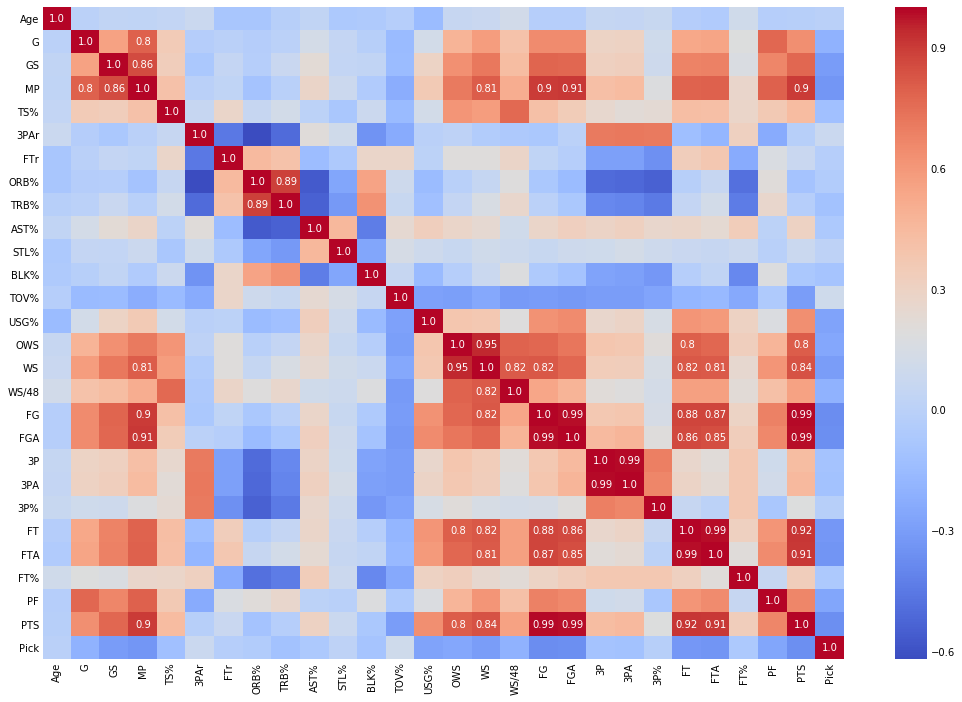

In [51]:
# Check correlations between the rest of features.
correlation = season_stats.drop(['Pos', 'Tm'], axis=1).corr()
# Make a heatmap with highlights on pairs of features with high correlations.
corr_annot = correlation.round(2)
corr_annot[corr_annot.abs()<0.8] = ''
_ = plt.figure(figsize=(16, 12))
_ = sns.heatmap(correlation, annot=corr_annot, cmap='coolwarm', fmt='')

The heatmap revealed several other problems with the dataset.
1. Cumulative data were correlated with each other.<br>
The more games/minutes a player played, the more stats he accumulated. These stats all correlate with each other. The solution is to transform these features to rates.
2. Offensive and total were correlated with each other.<br>
ORB% and TRB%, OWS and WS are highly correlated to each other. That's understandable, a good overall player is usually good on offense and defense. Because of their high correlation, seperating offense and defense provide little additional value. I will delete the offensive features.
3. Points(PTS) and various shot attemps and shot mades(FGA,FG,FT,FTA) were highly correlated.<br>
This is pretty simple, more (made) shots lead to more points. I will drop the points feature.
4. Shot made and shot attemps were highly correlated.<br>
Despite differences in shot accuracy, FG and FGA, 3P and 3PA, FT and FTA were highly correlated. I will keep the shot attempts.

In [52]:
# Drop ORB%, OWS, PTS, FG, 3P, FT
season_stats.drop(['ORB%', 'OWS', 'PTS', 'FG', '3P', 'FT'], axis=1, inplace=True)
# Convert GS into GS%
season_stats['GS%'] = season_stats['GS'].div(season_stats['G'])
season_stats.drop('GS', axis=1, inplace=True)
# Convert FGA, 3PA, FTA, PF into FGA and PF per 48 minutes
season_stats['FGA/48'] = 48 * season_stats['FGA'].div(season_stats['MP'])
season_stats['3PA/48'] = 48 * season_stats['3PA'].div(season_stats['MP'])
season_stats['FTA/48'] = 48 * season_stats['FTA'].div(season_stats['MP'])
season_stats['PF/48'] = 48 * season_stats['PF'].div(season_stats['MP'])
season_stats.drop(['FGA', '3PA', 'FTA', 'PF'], axis=1, inplace=True)
# Convert MP into MP/G
season_stats['MPG'] = season_stats['MP'].div(season_stats['G'])
season_stats.drop('MP', axis=1, inplace=True)

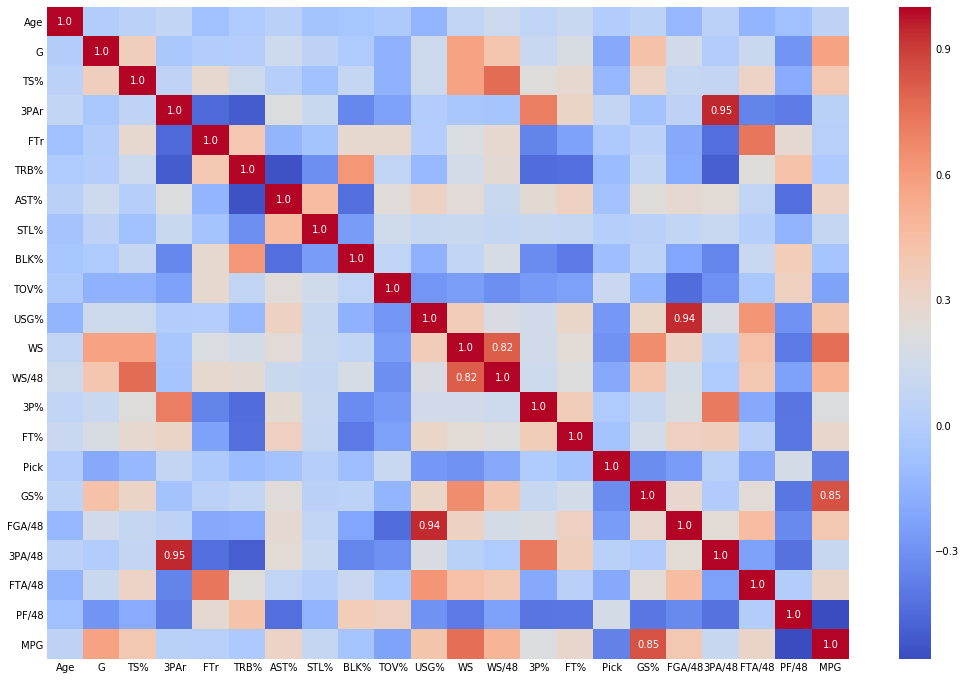

In [53]:
# Check correlations between the rest of features.
correlation = season_stats.drop(['Pos', 'Tm'], axis=1).corr()
# Make a heatmap with highlights on pairs of features with high correlations.
corr_annot = correlation.round(2)
corr_annot[corr_annot.abs()<0.8] = ''
_ = plt.figure(figsize=(16, 12))
_ = sns.heatmap(correlation, annot=corr_annot, cmap='coolwarm', fmt='')

In [54]:
# Save cleaned data
season_stats.to_csv('./data/clean_data.csv')
season_stats.shape

(13684, 24)